<a href="https://colab.research.google.com/github/martinpius/MachineTranslation/blob/main/Character_level_language_model_with_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from timeit import default_timer as timer
t1 = timer()
try:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  import torch, random
  from torch.nn import functional as F
  from tqdm.auto import tqdm
  import matplotlib.pyplot as plt
  print(f">>>> You are in CoLaB notbook weith torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload")

def mytimer(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h}, mins: {m:>02}, secs: {s:>05.2f}"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 64 if device == torch.device("cuda") else 32
print(f">>>> Available device: {device}")
!nvidia-smi
print(f">>>> Time elapsed: \t {mytimer(timer() - t1)}")



Mounted at /content/drive/
>>>> You are in CoLaB notbook weith torch version: 2.0.0+cu118
>>>> Available device: cpu
/bin/bash: nvidia-smi: command not found
>>>> Time elapsed: 	 hrs: 0, mins: 00, secs: 37.00


* We build a deep MLP as a character level language model to predict the probability
distribution of the next character given a sequence of characters. This is the language 
generation model. We employ the dataset by Andrej Karpathy which can be found here: https://github.com/karpathy/makemore

In [2]:
# Loading and explore the dataset
data_path = "/content/drive/MyDrive/Language models/makemore-master/names.txt"
names = open(data_path, "r").read().splitlines()
print(f">>>> Total number of example in names dataset is: {len(names)}\
\n>>>> The longest name has {max([len(name) for name in names])} characters\
\n>>>> The shortest name has {min([len(name) for name in names])} characters\
\n>>>> The first 10 names are: {names[:10]}")

>>>> Total number of example in names dataset is: 32033
>>>> The longest name has 15 characters
>>>> The shortest name has 2 characters
>>>> The first 10 names are: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


# Data preparations steps: 
* We build a lookup dictionaries to map characters to numeric and vice-versa
* We obtain list of unique character in the entire dataset
* We padd every name with a special token to identify the starting and ending of a name
* We create a padd index as zero
* We create the dataset with sequence length of 3 (can be set as hyperparameter to be optimized by the network
* We split the dataset into train, validation and test splits

In [3]:
def myTextDataset(words_list):

  all_chars = sorted(list(set("".join(words_list)))) # Fetch all unique characters as a sorted list
  assert len(all_chars) == 26 # I know this prior-since they are english names
  stoi = {s : i + 1 for i, s in enumerate(all_chars)} # map char to index
  stoi["."] = 0 # Add a padding token as 0 index
  itos = {i: s for s, i in stoi.items()} # reconvert back to characters
  assert len(stoi) == len(itos) == 27 # since we added a special token "."

  seq_len = 3 # create the block size i.e, we need data in shape [abc -> d, bcd->e, etc]
  # building the dataset
  inputs, labels = [], []
  for name in words_list:
    context = [0]*seq_len # start with a sequence of padding characters 
    name = name + "." # adding a padding character
    for ch in name:
      idx = stoi[ch] # grab the respective index
      inputs.append(context), labels.append(idx) # Append the respective inputs and outputs indices
      context = context[1:] + [idx] # updating a context vector
  inputs, labels = torch.tensor(inputs), torch.tensor(labels) # Cast the results into torch.Tensor
  return stoi, itos, all_chars, inputs, labels


In [4]:
# We can now buid our dataset
n1, n2 = int(len(names) * 0.8), int(len(names) *0.9) # We split the data into 80% train, 10% val, & 10 test
random.shuffle(names) # We shuffle the data before splitting to create randomness
train = names[:n1] # Fetch the 80 % training set
valid = names[n1:n2] # Fetch the 10 % validation split
test = names[n2:] # Fetch the remaing 10 % for testing
stoi, itos, all_chars, X_tr, Y_tr = myTextDataset(words_list = train)
_, _,_, X_val, Y_val = myTextDataset(words_list = valid)
_, _,_, X_test, Y_test = myTextDataset(words_list = test)

In [5]:
print(f">>>> List of all unique characters in the dataset:\n {all_chars}\
\n>>>> stoi: \n {stoi}\n>>>> itos: \n {itos}\
\n\n>>>> X_train shape: {X_tr.shape}, Y_train shape: {Y_tr.shape}\
\n>>>> X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}\
\n>>>> X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

>>>> List of all unique characters in the dataset:
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
>>>> stoi: 
 {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
>>>> itos: 
 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

>>>> X_train shape: torch.Size([182536, 3]), Y_train shape: torch.Size([182536])
>>>> X_val shape: torch.Size([22788, 3]), Y_val shape: torch.Size([22788])
>>>> X_test shape: torch.Size([22822, 3]), Y_test shape: torch.Size([22822])


In [6]:
# We can now Create our deep MLP to train a language model to generate new names 

In [13]:
class LinearLayer:
  """""
  This class implement the Linear layer in MLP
  """""
  def __init__(self, in_dim, out_dim, bias = True):

    # We use kaiming initialization for the weights
    self.weight = torch.randn(size = (in_dim, out_dim),
                              generator = gen) * (1/in_dim **2)
    self.bias = torch.zeros(out_dim) # initialize the bias to zero
  
  def __call__(self, input_tensor: torch.Tensor)->torch.Tensor:
    self.out = torch.mm(input_tensor, self.weight)
    if self.bias is not None: # We do not need bias for batchnorm layer
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
  """""
  This class implement a tanh activation function
  """""
  def __call__(self, input_tensor: torch.Tensor)->torch.Tensor:
    self.out = torch.tanh(input_tensor)
    return self.out
  
  def parameters(self):
    return []

class Batchnorm1d:
  """""
  This class implement batch normalization layer for MLP
  Parameters: mean, var ==> beta, gamma
  momentum: fixed to 0.1 to adjust the batchnorm parameters for evaluation
  eps: small constant to avoid division by a zero variance
  dim: is the output dimension of the linear layer just before a batchnorm layer
  """""
  def __init__(self, dim, momentum = 0.1, eps = 1e-6):

    self.dim = dim
    self.training = True
    self.momentum = momentum
    self.eps = eps
    self.gamma = torch.ones(self.dim)
    self.beta = torch.zeros(self.dim) 
    self.rnmean = torch.zeros(self.dim)
    self.rnvar = torch.ones(self.dim)

  def __call__(self, input_tensor: torch.Tensor)->torch.Tensor:
    if self.training: # We learn the beta & gamma params
      xmean = input_tensor.mean(dim = 0, keepdims = True) # compute the batch mean
      xvar = input_tensor.var(dim = 0, keepdims = True) # compute the batch variance
    else: # We set a fixed mean and var which is updated wrt momentum 
      xmean = self.rnmean
      xvar = self.rnvar
    x_hat = (input_tensor - xmean) / torch.sqrt(xvar + self.eps) # normalize the batch
    self.out = self.gamma * x_hat + self.beta # We scale and centering the otput of batchnorm [pars to be learned]

    # We update the rnmean and rnvar depending on momentum and the learned barchnorm pars 
    if self.training: # We do the update of the buffer during training but no grad is required
      with torch.no_grad():
        self.rnmean = (1-self.momentum) * self.rnmean + self.momentum * xmean #updating the buffer's mean
        self.rnvar = self.rnvar * (1-self.momentum) + self.momentum * xvar # updating the buffer's variance
    
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


In [14]:
# We can now instantiating our MLP language model using the above defined classes as follows
seq_len = 3
embd_dim = 10
hidden_dim = 200
vocab_size = 27
gen = torch.Generator().manual_seed(239101)
Wo = torch.randn(size = (vocab_size, embd_dim), generator = gen) # Embedding weights tensor

MLPs = [
    LinearLayer(in_dim = embd_dim * seq_len, out_dim = hidden_dim), Batchnorm1d(hidden_dim), Tanh(),
    LinearLayer(in_dim = hidden_dim, out_dim = hidden_dim),Batchnorm1d(hidden_dim), Tanh(),
    LinearLayer(in_dim = hidden_dim, out_dim = hidden_dim),Batchnorm1d(hidden_dim), Tanh(),
    LinearLayer(in_dim = hidden_dim, out_dim = hidden_dim),Batchnorm1d(hidden_dim), Tanh(),
    LinearLayer(in_dim = hidden_dim, out_dim = vocab_size)
]

# use the gain of 0.1 for the output layer and 5/3 for the hidden layer
with torch.no_grad():
  MLPs[-1].weight *= 0.1
  for layer in MLPs:
    if isinstance(layer, LinearLayer):
      layer.weight *= 5/3

params = [Wo] + [p for layer in MLPs for p in layer.parameters()]
print(f">>>> The deep MLP has {sum([p.numel() for p in params]):,} parameters")



>>>> The deep MLP has 134,097 parameters


In [15]:
for par in params: par.requires_grad = True 

In [16]:
# Assess if everthing works fine
EMB = Wo[X_tr]
EMB = EMB.view(EMB.shape[0], -1)
for layer in MLPs:
  EMB = layer(EMB)
assert EMB.shape == (EMB.shape[0], vocab_size)

  0%|          | 0/20000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
>>>> Epoch 15001:	 Train Loss: 2.7513
>>>> Epoch 15002:	 Train Loss: 1.8971
>>>> Epoch 15003:	 Train Loss: 2.2166
>>>> Epoch 15004:	 Train Loss: 2.4201
>>>> Epoch 15005:	 Train Loss: 1.8726
>>>> Epoch 15006:	 Train Loss: 2.1727
>>>> Epoch 15007:	 Train Loss: 2.3356
>>>> Epoch 15008:	 Train Loss: 2.3973
>>>> Epoch 15009:	 Train Loss: 2.4800
>>>> Epoch 15010:	 Train Loss: 2.3437
>>>> Epoch 15011:	 Train Loss: 2.4550
>>>> Epoch 15012:	 Train Loss: 2.1180
>>>> Epoch 15013:	 Train Loss: 2.1361
>>>> Epoch 15014:	 Train Loss: 2.4818
>>>> Epoch 15015:	 Train Loss: 1.9478
>>>> Epoch 15016:	 Train Loss: 2.2805
>>>> Epoch 15017:	 Train Loss: 2.2781
>>>> Epoch 15018:	 Train Loss: 2.4077
>>>> Epoch 15019:	 Train Loss: 2.1760
>>>> Epoch 15020:	 Train Loss: 2.0190
>>>> Epoch 15021:	 Train Loss: 2.4935
>>>> Epoch 15022:	 Train Loss: 2.2741
>>>> Epoch 15023:	 Train Loss: 2.1380
>>>> Epoch 15024:	 Train Loss: 2.3963
>>>> Epoch 15025:	 Train Loss: 2.7471

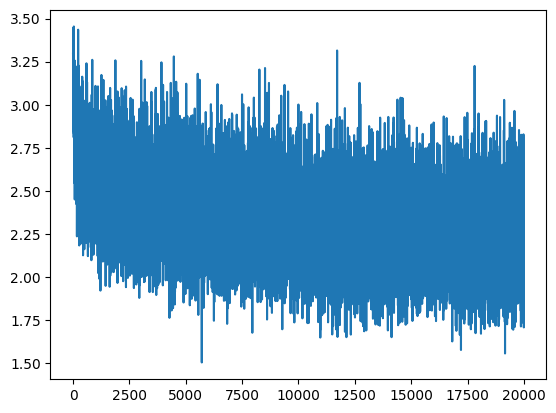

In [17]:
# The training loop:
EPOCHS = 20000
all_loss = []
steps = []
nll = 0
for epoch in tqdm(range(EPOCHS)):
  ix = torch.randint(0, X_tr.shape[0], (BATCH_SIZE,)) # sample the minibatch of size BATCH_SIZE
  x_em = Wo[X_tr[ix]] # Get the embedding for the batch
  x_em = x_em.view(x_em.shape[0], -1)

  # Running the forward prop
  for layer in MLPs:
    x_em = layer(x_em)
  tr_loss = F.cross_entropy(x_em, Y_tr[ix]) # Fetch loss
  print(f">>>> Epoch {epoch + 1 if epoch == 0 else epoch}:\t Train Loss: {tr_loss.item():.4f}")

  # Running the backward pass
  for layer in MLPs:
    layer.out.retain_grad()
    for par in params:
      par.grad = None
  tr_loss.backward()

  LR = 0.1 if epoch < 10000 else 0.01 # Decay the learning rate after half epochs training
  for par in params:
    par.data +=-LR * par.grad
  all_loss.append(tr_loss.item())
  steps.append(epoch)
  nll += tr_loss.mean()

print(f">>>> Average training loss: {nll / EPOCHS:.4f}")

plt.plot(steps, all_loss)


In [ ]:
plt.plot([0, 1000], [-3,-3], "k")